In [1]:
#install dependencies
!pip install networkx[default]
!pip install torch_geometric

# Optional dependencies:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 51.6 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import os
import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv

import networkx as nx

#import zipfile module
from zipfile import ZipFile
#import my files
from get_graph import get_pandas_df, A_matrix,create_data_object,create_dataset_objs
from get_model import simpleGNN, accuracy, train
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


2.1.0+cu121


# Load and preprocess data

In [3]:
#Manually drop zip

with ZipFile('Blood Glucose Prediction Challenge.zip', 'r') as f:
  #extract in current directory
  f.extractall()

In [4]:
!python3 preprocess.py

/content/Ohio Data/Ohio2018_processed/train
Dropped missing_cbg in/content/Ohio Data/Ohio2018_processed/train/588-ws-training_processed.csv
Dropped missing_cbg in/content/Ohio Data/Ohio2018_processed/train/563-ws-training_processed.csv
Dropped missing_cbg in/content/Ohio Data/Ohio2018_processed/train/575-ws-training_processed.csv
Dropped missing_cbg in/content/Ohio Data/Ohio2018_processed/train/570-ws-training_processed.csv
Dropped missing_cbg in/content/Ohio Data/Ohio2018_processed/train/559-ws-training_processed.csv
Dropped missing_cbg in/content/Ohio Data/Ohio2018_processed/train/591-ws-training_processed.csv
Dropped empty rows in/content/Ohio Data/Ohio2018_processed/train/588-ws-training_processed.csv
Dropped empty rows in/content/Ohio Data/Ohio2018_processed/train/563-ws-training_processed.csv
Dropped empty rows in/content/Ohio Data/Ohio2018_processed/train/575-ws-training_processed.csv
Dropped empty rows in/content/Ohio Data/Ohio2018_processed/train/570-ws-training_processed.csv


In [ ]:
# @title Analyse correlation between features
##Analyse each training data in both 2018 and 2020

#2018
def plot_corr():
  directory = os.getcwd()
  for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    df = pd.read_csv(file_path)
    #get column labels without index
    labels = df.columns.values.tolist()
    #create figures
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(df.corr(), interpolation='nearest')
    #set side colorbar
    fig.colorbar(cax)
    # set ticks and labels
    ax.set_xticklabels(['']+labels)
    ax.set_yticklabels(['']+labels)

    plt.show()

plot_corr()
#in 2018 corr between cbg-finger, carbInput-bolus, and occasionally hr-gsr

In [5]:
# @title
#2020
#goes back to /content
!pwd
!mkdir Checkpoints
%cd /content/Ohio Data/Ohio2020_processed/train
#plot_corr()
#in 2020 hr is correlated with everything

/content
/content/Ohio Data/Ohio2020_processed/train


As shown in the correlation graphs in 2018 significant correlations were found only between cbg-finger, carbInput-bolus, and occasionally hr-gsr. While in 2020, hr was not present.

In [6]:
# @title Create training df
!pwd
from get_graph import get_pandas_df, A_matrix,create_data_object,create_dataset_objs
from get_model import simpleGNN, accuracy, get_epochs_and_in_feat,train

#Labels
columns_2018 = ['cbg', 'finger', 'hr', 'gsr', 'carbInput', 'bolus']
columns_2020 = ['cbg', 'finger', 'gsr', 'carbInput', 'bolus']

/content/Ohio Data/Ohio2020_processed/train


# Patient 559

In [7]:
# patient 559
file_path = '/content/Ohio Data/Ohio2018_processed/train/559-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2018_processed/test/559-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')

# #Plot train_df(it only has 2 values), while val_df only 1
# for c in columns_2018[1:]:
#     plt.plot(train_df.index, train_df[c], label=c)

# plt.xticks(rotation=90)
# plt.legend()
# plt.ylabel("mg/dL")
# plt.xlabel("Time")
# plt.title(train_file_name[:3]+" "+train_file_name[7:15])
# plt.show()

train_df, val_df created
test_df created


In [8]:
# @title
#Create adjecency matrix
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
# # Visualize the adjacency matrix
# plt.imshow(train_A, cmap='Greys', origin='upper')
# plt.title('Adjacency Matrix')
# plt.show()

# # Create a graph using NetworkX for visualization (optional)
# G = nx.DiGraph(train_A)

# # Visualize the graph
# pos = nx.spring_layout(G)  # Choose a layout algorithm
# nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue')
# plt.title('Graph Representation')
# plt.show()

In [9]:
# @title
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2018)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")

test_data is empty, using val_data as test_data
Train and validation to Test Data are available.


/content/Ohio Data/Ohio2020_processed/train
Epoch 1/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 12/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch

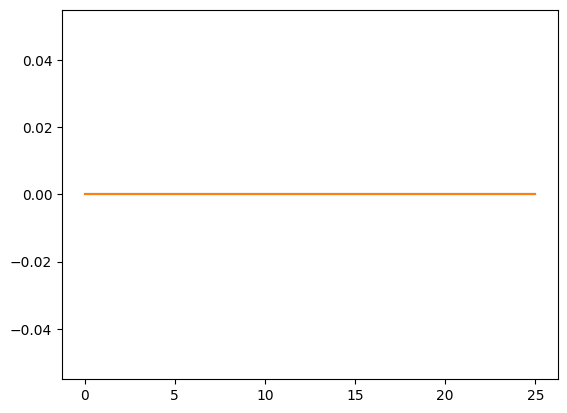

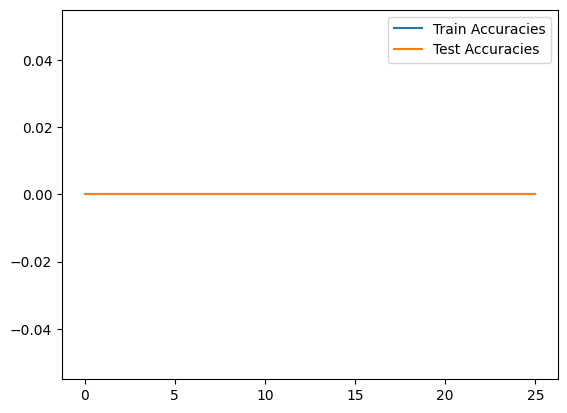

Enter patient number: 559


In [10]:
# @title
#train
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 563

train_df, val_df created
test_df created
Train, Validation, and Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0

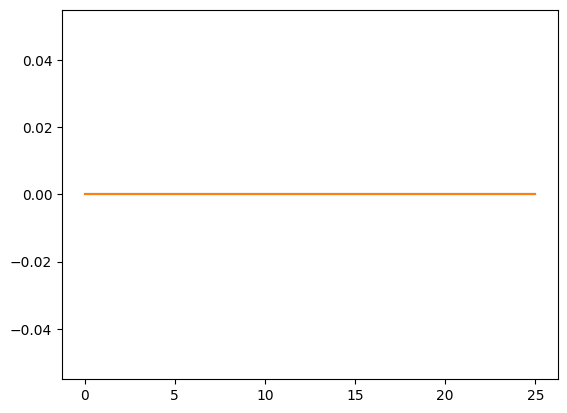

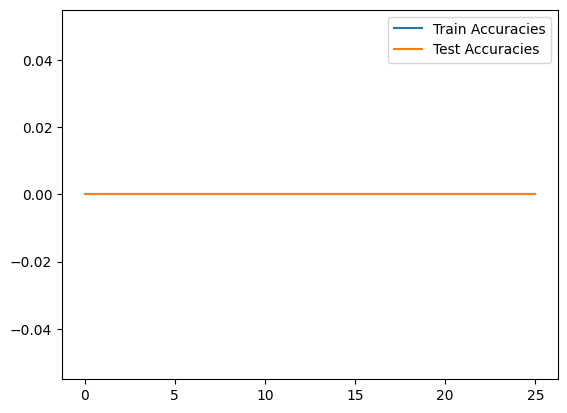

Enter patient number: 563


In [11]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2018_processed/train/563-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2018_processed/test/563-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2018)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

# **Patient 570**

train_df, val_df created
test_df created
Train, Validation, and Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0

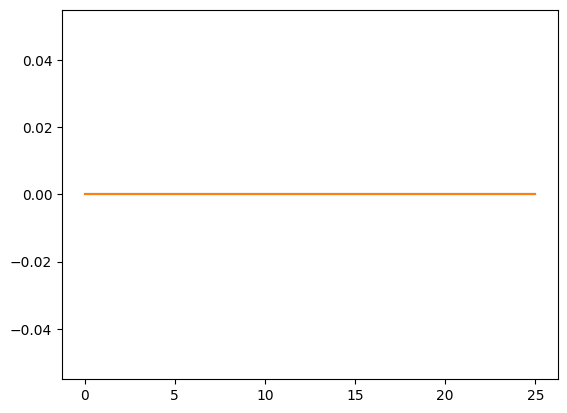

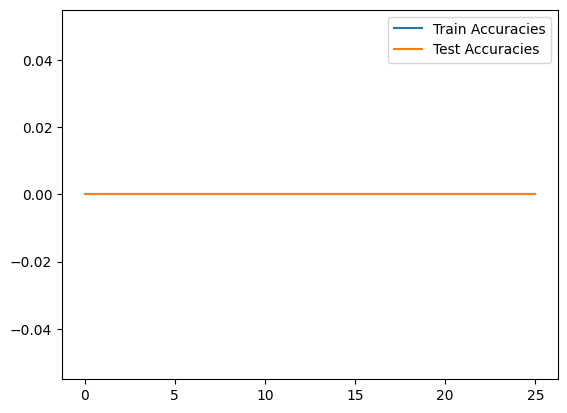

Enter patient number: 570


In [12]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2018_processed/train/570-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2018_processed/test/570-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2018)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 575

train_df, val_df created
test_df created
Train, Validation, and Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0

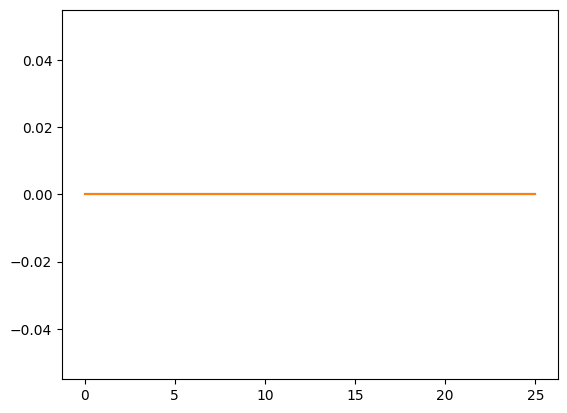

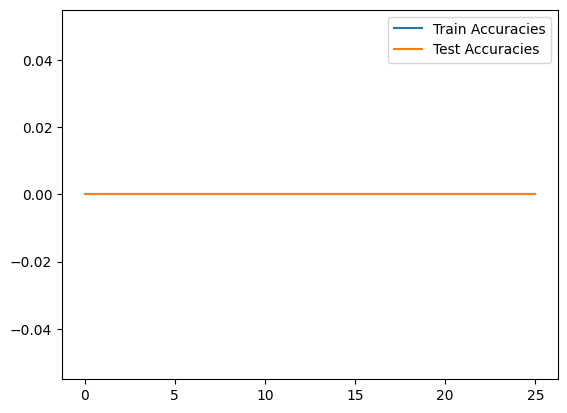

Enter patient number: 575


In [13]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2018_processed/train/575-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2018_processed/test/575-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2018)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 588

train_df, val_df created
test_df created
Train, Validation, and Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0

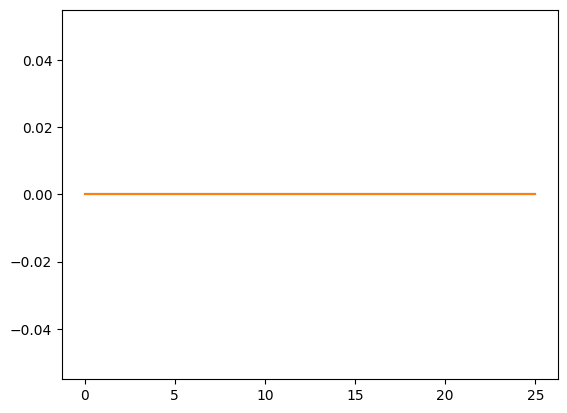

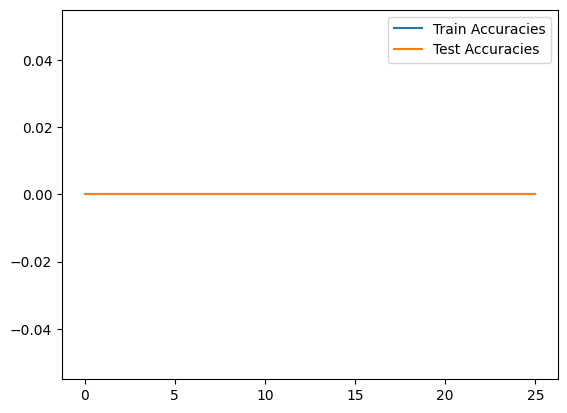

Enter patient number: 588


In [14]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2018_processed/train/588-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2018_processed/test/588-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2018)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 591

train_df, val_df created
test_df created
Train, Validation, and Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/25, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0

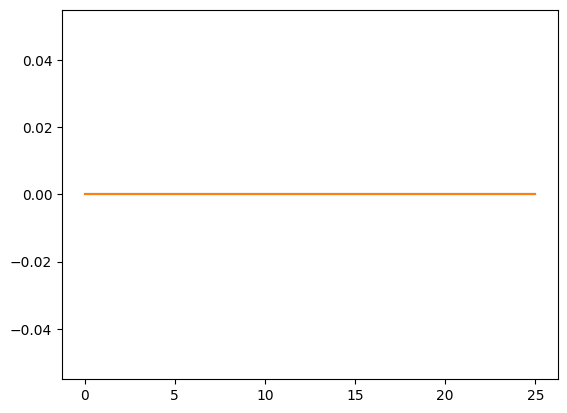

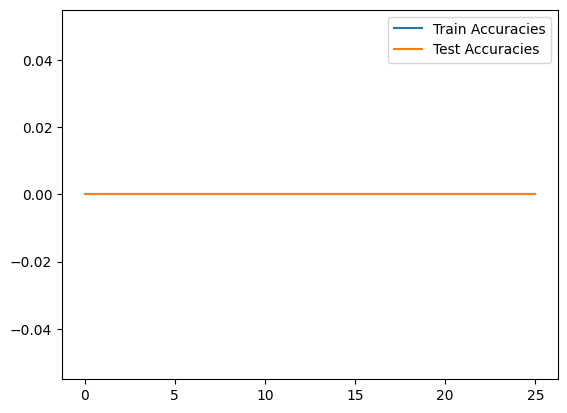

Enter patient number: 591


In [15]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2018_processed/train/591-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2018_processed/test/591-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2018)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 540

train_df, val_df created
test_df created
test_data is empty, using val_data as test_data
Train and validation to Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/16, Train_Loss: -0

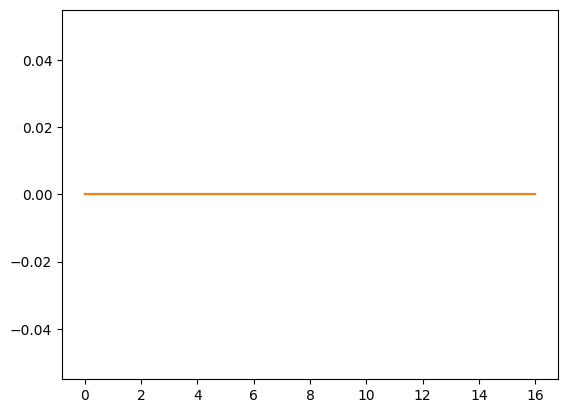

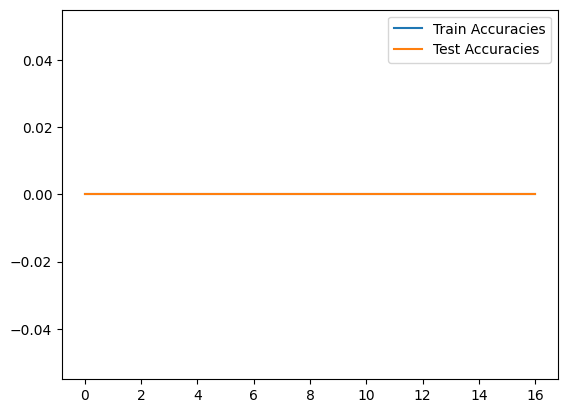

Enter patient number: 540


In [7]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2020_processed/train/540-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2020_processed/test/540-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2020)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 544

train_df, val_df created
test_df created
Train, Validation, and Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0

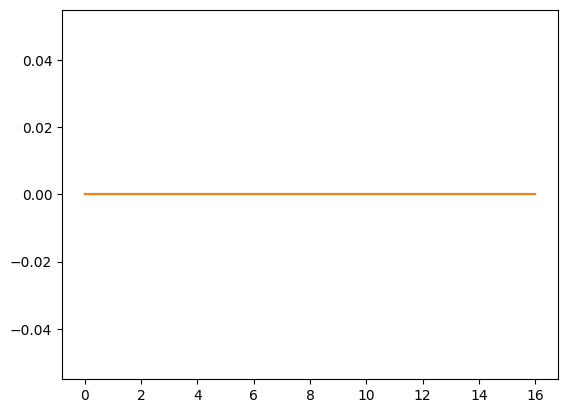

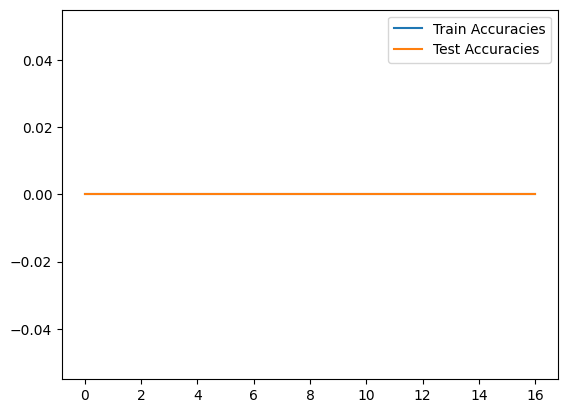

Enter patient number: 544


In [8]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2020_processed/train/544-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2020_processed/test/544-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2020)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

#Patient 552: empty training dataset

In [9]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2020_processed/train/552-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2020_processed/test/552-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2020)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#Patient 567: empty training dataset

In [10]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2020_processed/train/567-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2020_processed/test/567-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2020)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#Patient 584: only 1 sample

In [11]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2020_processed/train/584-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2020_processed/test/584-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2020)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#Patient 596

train_df, val_df created
test_df created
test_data is empty, using val_data as test_data
Train and validation to Test Data are available.
/content/Ohio Data/Ohio2020_processed/train
Epoch 1/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 2/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 3/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 4/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 5/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 6/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 7/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 8/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 9/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 10/16, Train_Loss: -0.0000, Train_Accuracy: 0.0000, Test_Accuracy: 0.0000
Epoch 11/16, Train_Loss: -0

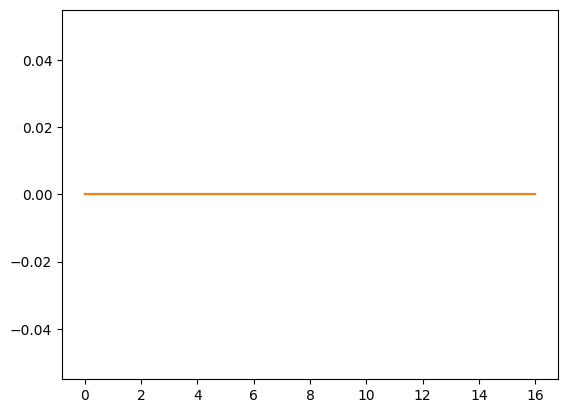

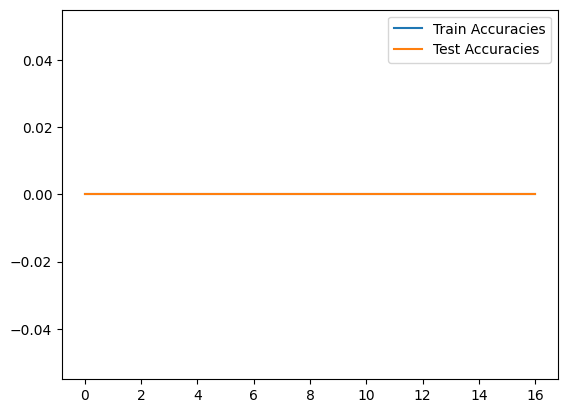

Enter patient number: 596


In [12]:
#creating dataframes
file_path = '/content/Ohio Data/Ohio2020_processed/train/596-ws-training_processed.csv'
dataframe = get_pandas_df(file_path)

if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
file_path = '/content/Ohio Data/Ohio2020_processed/test/596-ws-testing_processed.csv'
dataframe = get_pandas_df(file_path)
if dataframe is not None:
  if len(dataframe) == 2:
      train_df, val_df = dataframe
      print('train_df, val_df created')
  else:
      test_df = dataframe
      print('test_df created')
#Creating adjecency matrices
train_A = A_matrix(train_df)
val_A = A_matrix(val_df)
test_A = A_matrix(test_df)
#Create Pytorch geometric Data obj
result = create_dataset_objs(train_df, val_df, test_df, train_A, val_A, test_A, columns_2020)
# Check the result and use it accordingly
if result is not None:
    if len(result) == 2:
        train_data, test_data = result
        print("Train and validation to Test Data are available.")
        # Process train_data and test_data accordingly
    elif len(result) == 3:
        train_data, val_data, test_data = result
        print("Train, Validation, and Test Data are available.")
        # Process train_data, val_data, and test_data accordingly
    else:
        print("No Data available.")
#train (number of fetures and epochs function already defined)
!pwd
num_of_feat, epochs = get_epochs_and_in_feat(train_data)
net=simpleGNN(num_of_feat=num_of_feat,f=16)
train(net,train_data, test_data,epochs)

# Federated Averaging

In [19]:
#load checkpoints
model = torch.load('/content/Checkpoints/540.pth')
print(model.keys())#odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight'])

def weight_scaling_factor(train_df):
  global count = get sum of num_of_feat across all patients
  local count= num of feat of current patient
  scaling_patient = local_count / global_count
  return scaling_patient


def scale_model_weights(weights, weight_scaling_factor):
  # weights = model['conv1.lin.weight']+model['conv2.lin.weight']
  #scaling factor = list of all scaling patients
  scaled_weights = []
  # Scale each layer's weights
  for w in weights:
      scaled_weights.append(scaling_factor* w.clone().detach())
  return scaled_weights

def mean_scaled_weights(scaled_weights):
  return torch.mean(scaled_weights)


odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight'])


Federated model training



In [ ]:
def federated_training(model, scaled_weights):
    # Initialize an empty tensor for the aggregated weights
    #my global simpleGNN is initialised as with zeros as weights and biases
    model.load_state_dict(torch._scaled_dot_product_attention_math_weights)